# Assignment 2: object classification

In [1]:
# Imports
import os # Module to access Operating System
import keras # Module for deep learning
!pip -q install keras-cv > /dev/null
import keras_cv # Keras module for object detection
import numpy as np # Module for matrix operations and linear algebra
import seaborn as sns # Module for plotting
import tensorflow as tf # Module for deep learning
from keras import backend as K # Module for tensor operations
import matplotlib.pyplot as plt # Module for plotting
from sklearn.metrics import confusion_matrix # Module for model evaluation
from keras.applications.resnet50 import ResNet50 # Pretrained ResNet50 model

The system cannot find the path specified.


## Data analysis

In the first step, we will download the data. The data will be stored in several folders per class. Each class folder contains images of the corresponsing class. Next, we define a Dataloader for the train and testset that allow the network to retrieve the dataset in batches. We use a batch size of 9. Next, we split the validation dataset in a validation and test set. We also visualize some samples from the dataset. 

In [2]:
# Download data
if not os.path.exists('data/fish_data_classification'):
    !wget -q --no-check-certificate -O dataset.zip "https://kuleuven-my.sharepoint.com/:u:/g/personal/matthias_deryck_kuleuven_be/Ed2e5ehats5Ery2K15Gzos0B6AlAOKnBoA8FMTRm3Xmkrw?e=2G6qWx&download=1"
    !unzip -q dataset.zip -d data
    !rm dataset.zip

In [19]:
# Define class list
class_list = ['ANF', 'BIB', 'GUU', 'PLE', 'SOL', 'WIT']

# Define batch size
batch_size = 9

# Get Dataloader for the training set (70%)
train_ds = keras.utils.image_dataset_from_directory("./data/fish_data_classification/", validation_split=0.3, subset="training", seed=1337, image_size=(150, 150), batch_size=batch_size)

# Get Dataloader for the validation set (30%)
val_ds = keras.utils.image_dataset_from_directory("./data/fish_data_classification/", validation_split=0.3, subset="validation", seed=1337, image_size=(150, 150), batch_size=batch_size)

# Split validation set further in 15% validation and 15% testset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((val_batches) // 2)
val_ds = val_ds.skip((val_batches) // 2)

# Print results
print(f'\nThe validation set contains {len(val_ds)*batch_size} samples')
print(f'\nThe test set contains {len(test_ds)*batch_size} samples')

Found 120 files belonging to 6 classes.
Using 84 files for training.
Found 120 files belonging to 6 classes.
Using 36 files for validation.

The training set contains 90 samples

The validation set contains 18 samples

The test set contains 18 samples


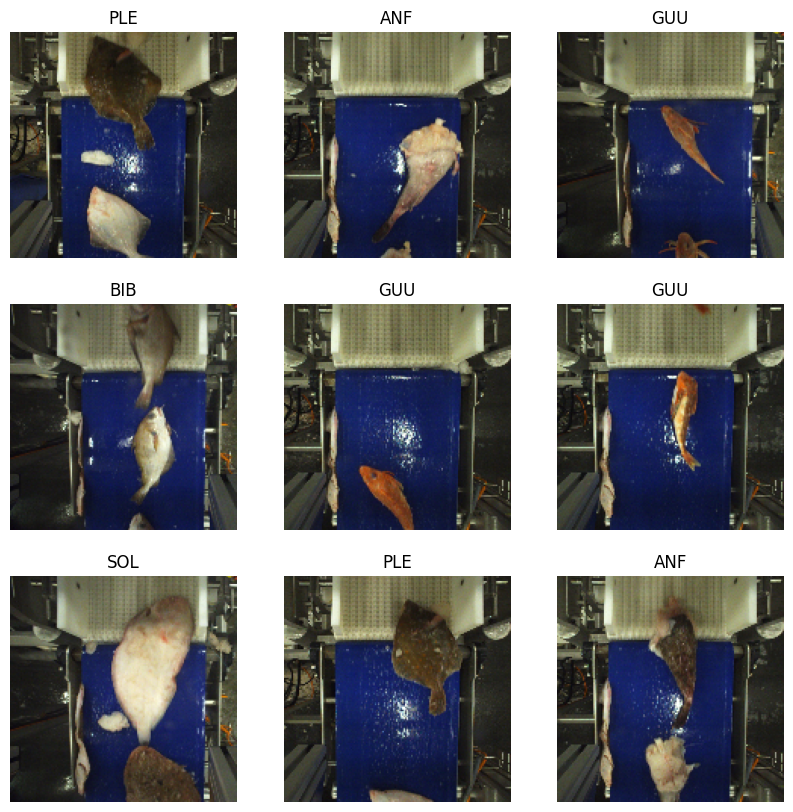

In [5]:
# Plot one batch in grid
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_list[int(labels[i])])
        plt.axis("off")

## Data preprocessing

As we have limited data, data augmentation can help improving the model performance. In this case, we perform a random horizontal flip of the image, and a random rotation of the image with a probability of 10%. We apply the data augmentation to the train images and visualize some augmented images. 

In [6]:
# Define data augmentation layers
data_augmentation_layers = [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
]

# Define data augmentation function
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Apply data_augmentation to the training images.
train_ds = train_ds.map(lambda img, label: (data_augmentation(img), label), num_parallel_calls=tf.data.AUTOTUNE)

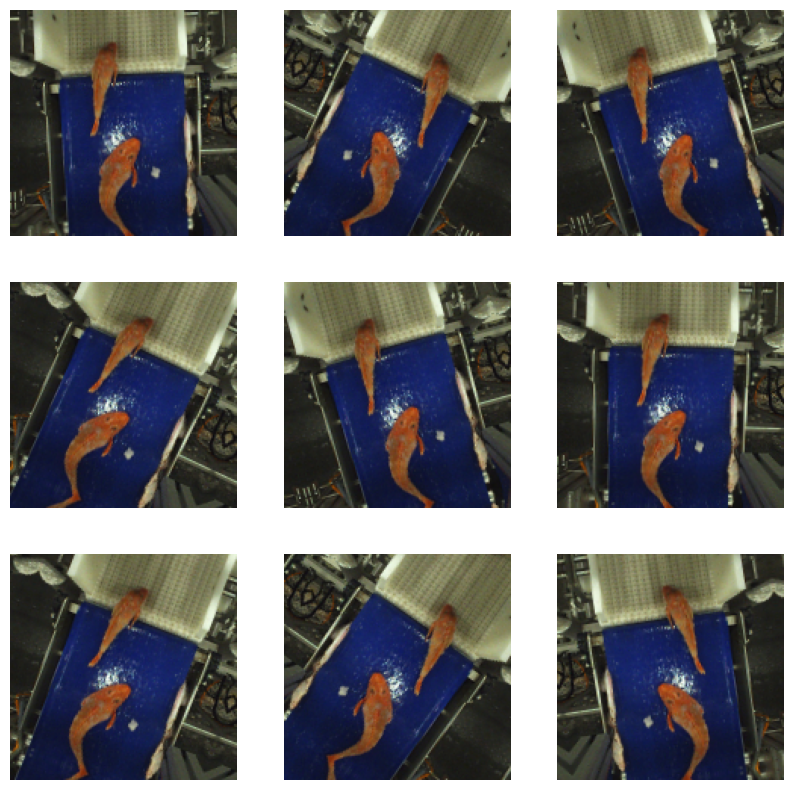

In [7]:
# Plot one batch in grid
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

For a full and efficient usage of the GPU and CPU, we apply the following methods to each Dataloader that take care of this. 

In [8]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

## Model training

In the next step, we will train our model. The model that we use is a pretrained ResNet50 model that was trained on ImageNet. We only use the feature extraction part of this model, not the classification part, this we will define ourself. Therefore, we make a new model with the feature extraction layers and a new fully connected output layer. We finetune the full model, thus the feature extraction part, and the classification part. 

In [9]:
# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Set the parameters of the feature extraction part as also trainable
base_model.trainable = True

# Get the output layer of the base model (the output of the feature extraction part)
x = base_model.output

# Convert the features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# Apply a dense classifier with six output units (we have six classes)
outputs = keras.layers.Dense(6, activation='softmax')(x)

# Define final model
model = keras.Model(base_model.input, outputs)

# Summarize final model
#model.summary(show_trainable=True)

After defining the model, we can compile it with the proper optimizer, loss function, and evaluation metrics. After that we can train it for the specified number of epochs. First, we define some functions that will calculate some interesting evaluation metrics after each epoch: recall, precision, and f1-score.

In [10]:
# Function to compute the average recall
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (all_positives + K.epsilon())
    return recall

# Function to compute the average precision
def precision(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Function to compute average F1 score
def f1_score(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+K.epsilon()))

In [11]:
# Set number of epochs to train
epochs = 30

# Set optimizer, loss function, and evaluation metrics
model.compile(
    optimizer=keras.optimizers.SGD(), # Stochastic gradient descent optimizer
    loss=[keras.losses.SparseCategoricalCrossentropy()], # Crossentropy loss for multi-class classification
    metrics=[keras.metrics.SparseCategoricalAccuracy(), f1_score, precision, recall]) # Crossentropy accuracy for multi-class classification

# Train model
hist = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=epochs, 
)

Epoch 1/30


AttributeError: module 'keras.backend' has no attribute 'ones_like'

## Model validation

During training, the model was evaluated on the training and the validation set. It is important to also evaluate the model on a set of images that it has never seen before. So we evaluate it again on the test set and we also compute the confusion matrix. Lastly, we loop over several images in the dataset and predict the class as if we would do in production. 

In [ ]:
# Evaluate model on test set
result = model.evaluate(test_ds)

# Print result
print(f'\nThe model has an accuracy of {result[1]*100}% on the test set')
print(f'\nThe model has an precision of {result[3]*100}% on the test set')
print(f'\nThe model has an recall of {result[4]*100}% on the test set')
print(f'\nThe model has an F1-score of {result[2]*100}% on the test set')

In [ ]:
# Load batch and save predictions for confusion matrix
y_pred = []
y_true = []
for images, labels in test_ds:
	y_pred += list(np.argmax(model.predict(images), axis = 1))
	y_true += list(labels.numpy())

# Plot confusion matrix
ax= plt.subplot()
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_list)
ax.yaxis.set_ticklabels(class_list)

In [ ]:
# Loop over all folders and predict the class for the first image
for specie in class_list:

    # Define image path of the first image in the folder
    image_path = "./data/fish_data_classification/" + specie + "/" + os.listdir("./data/fish_data_classification/" + specie)[0]
                                                    
    # Load image
    img = keras.utils.load_img(image_path, target_size=(150, 150))

    # Convert image to array
    input_arr = np.array([keras.utils.img_to_array(img)])

    # Make predictions (outputs probabilities for each function)
    predictions = model.predict(input_arr, verbose=0)

    # Get the class with the highest probability
    predicted_class = class_list[predictions.argmax()]

    # Print result
    print(f"\nThe model predicts {predicted_class} and the ground truth class is {specie}")

    # Show image
    plt.imshow(img)
    plt.show()